In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict, deque

In [2]:
bacteria = pd.read_csv("../../data/interactions/interaction_matrix.csv", sep=";")['bacteria']

display(bacteria.head())

0    ECOR-54
1      DIJ06
2    ECOR-52
3    ECOR-51
4    ECOR-55
Name: bacteria, dtype: object

In [3]:
def get_log_files():
    base_path = "../../dev/predictions/results/logs/"
    log_files = os.listdir(base_path)
    log_files = [f for f in log_files if f.endswith(".csv")]
    log_file = log_files.pop(0)
    logs = pd.read_csv(base_path + log_file, sep=";")
    logs['file'] = log_file
    for log_file in log_files:
        log = pd.read_csv(base_path + log_file, sep=";")
        log['file'] = log_file
        logs = pd.concat([logs, log], ignore_index=True)
    return logs

logs = get_log_files()
display(logs.head())

,fold,train_size,test_size,train_idx,test_idx,cv_groups,file
0,0,360,41,[ 0 2 3 4 5 6 7 8 9 10 11 ...,[ 1 34 40 42 47 58 61 73 74 75 93 1...,[ 2 35 41 43 48 59 62 74 76 94 101 1...,logs_T4LD_Group10Fold_CV.csv
1,1,361,40,[ 0 1 2 3 4 5 6 7 8 9 10 ...,[ 14 32 33 46 55 59 72 82 83 92 112 1...,[ 15 34 47 56 60 73 83 93 113 116 131 1...,logs_T4LD_Group10Fold_CV.csv
2,2,361,40,[ 0 1 2 3 7 8 9 10 11 12 13 ...,[ 4 5 6 31 35 45 54 60 71 77 79 ...,[ 5 6 32 46 55 61 72 78 92 115 118 1...,logs_T4LD_Group10Fold_CV.csv
3,3,361,40,[ 0 1 2 3 4 5 6 7 8 9 10 ...,[ 29 44 53 70 89 99 101 102 118 123 129 1...,[ 30 45 54 71 90 100 103 119 124 130 134 1...,logs_T4LD_Group10Fold_CV.csv
4,4,361,40,[ 0 1 2 3 4 5 6 7 8 9 10 ...,[ 15 19 24 28 41 43 52 69 111 113 128 1...,[ 16 20 25 29 42 44 53 70 112 114 129 1...,logs_T4LD_Group10Fold_CV.csv


In [4]:
def normalize_columns(logs):
    logs['train_idx'] = logs['train_idx'].apply(lambda x: list(map(int, x.strip("[]").split())) if isinstance(x, str) else x)
    logs['test_idx'] = logs['test_idx'].apply(lambda x: list(map(int, x.strip("[]").split())) if isinstance(x, str) else x)
    logs['cv_groups'] = logs['cv_groups'].apply(lambda x: list(map(int, x.strip("[]").split())) if isinstance(x, str) else x)
    return logs

logs = normalize_columns(logs)
display(logs.head())

,fold,train_size,test_size,train_idx,test_idx,cv_groups,file
0,0,360,41,"[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 34, 40, 42, 47, 58, 61, 73, 74, 75, 93, 10...","[2, 35, 41, 43, 48, 59, 62, 74, 76, 94, 101, 1...",logs_T4LD_Group10Fold_CV.csv
1,1,361,40,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[14, 32, 33, 46, 55, 59, 72, 82, 83, 92, 112, ...","[15, 34, 47, 56, 60, 73, 83, 93, 113, 116, 131...",logs_T4LD_Group10Fold_CV.csv
2,2,361,40,"[0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...","[4, 5, 6, 31, 35, 45, 54, 60, 71, 77, 79, 80, ...","[5, 6, 32, 46, 55, 61, 72, 78, 92, 115, 118, 1...",logs_T4LD_Group10Fold_CV.csv
3,3,361,40,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[29, 44, 53, 70, 89, 99, 101, 102, 118, 123, 1...","[30, 45, 54, 71, 90, 100, 103, 119, 124, 130, ...",logs_T4LD_Group10Fold_CV.csv
4,4,361,40,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[15, 19, 24, 28, 41, 43, 52, 69, 111, 113, 128...","[16, 20, 25, 29, 42, 44, 53, 70, 112, 114, 129...",logs_T4LD_Group10Fold_CV.csv


In [5]:
groups = set(group for groups in logs['cv_groups'] for group in groups)

print(f"Number of groups: {len(groups)}")
print(f"Number of bacteria: {len(bacteria)}")

Number of groups: 302
Number of bacteria: 402


---

Since `cv_groups` is extracted using the `test_idx` indices, at leasts parts of the original `cv_clusters` may be reconstructed.
One major problem is that `.unique()` was cast over `cv_groups` before logging it, which also sorts the results.
Therefore, attempt a statistical approach.

One important observation is that the actual values do not matter for the clusters.
That is to say, since these groups are only used in `GroupKFold`, their actual values do not matter, only where equal values lie.

## Attempt: Use the highest number of labels for each index

[[38. 66. 34.  0.  1.]
 [ 8. 66. 58.  0.  0.]
 [ 6. 58. 66.  0. 23.]
 [ 8. 39.  0.  0. 58.]
 [ 0.  1. 22.  0. 38.]]


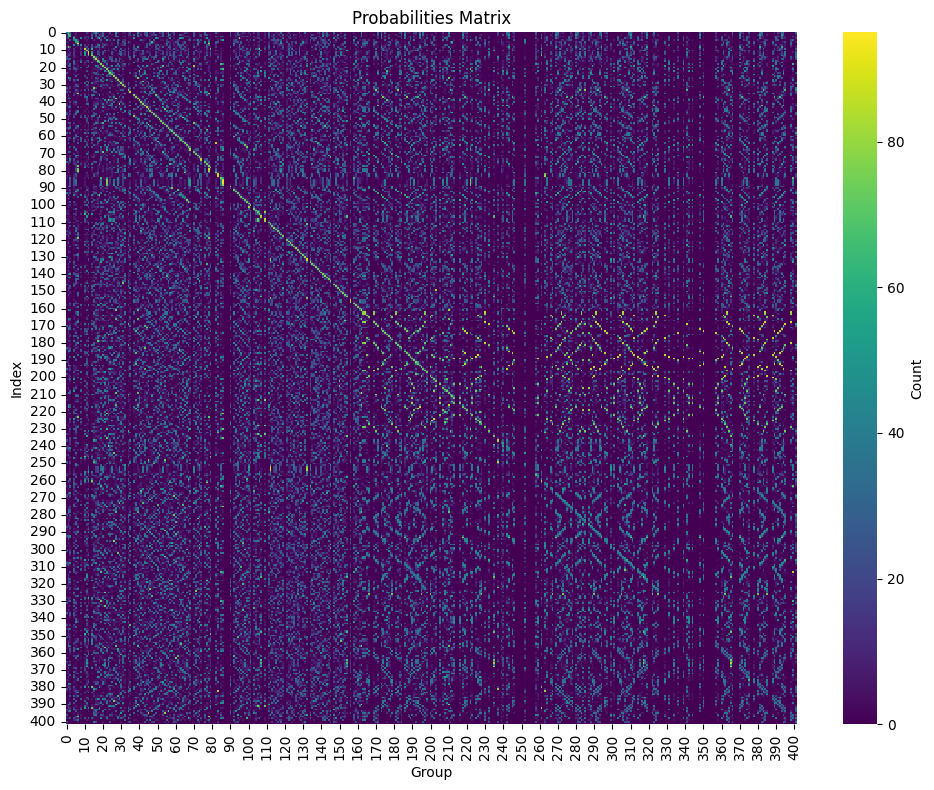

In [6]:
max_index = max(idx for indices in logs['test_idx'] for idx in indices) + 1
max_group = max(grp for groups in logs['cv_groups'] for grp in groups) + 1
probabilities = np.zeros((max_index, max_group))
for _, row in logs.iterrows():
    for index in row['test_idx']:
        for group in row['cv_groups']:
            probabilities[index, group] += 1
print(probabilities[0:5, 0:5])

plt.figure(figsize=(10, 8))
sns.heatmap(probabilities, cmap='viridis', cbar_kws={'label': 'Count'})
plt.title('Probabilities Matrix')
plt.xlabel('Group')
plt.ylabel('Index')
plt.tight_layout()
plt.show()

In [7]:
matching_rows = []
mismatching_rows = []
for i, row in logs.iterrows():
    inferred = np.unique([np.argmax(probabilities[idx, :]) for idx in row['test_idx']])
    expected = np.array(row['cv_groups'])
    if len(inferred) == len(expected) and (inferred == expected).all():
        matching_rows.append(row)
    else:
        mismatching_rows.append(row)

print(f"   Matching rows: {len(matching_rows):,}")
print(f"Mismatching rows: {len(mismatching_rows):,}")

   Matching rows: 0
Mismatching rows: 960


## Attempt: Graph-Clustering of overlapping test indices

In [8]:
def get_adjacency_list(logs):
    adjacency_list = defaultdict(set)
    for _, row in logs.iterrows():
        for i in row['test_idx']:
            for j in row['test_idx']:
                if i != j:
                    adjacency_list[i].add(j)
    return adjacency_list


graph = get_adjacency_list(logs)
print(f"Graph has {len(graph)} nodes and {sum(len(neighbors) for neighbors in graph.values())} edges.")

Graph has 402 nodes and 118624 edges.


In [9]:
# Find connected components
def connected_components(graph):
    visited = set()
    components = []
    for node in graph:
        if node not in visited:
            queue = deque([node])
            component = set()
            while queue:
                n = queue.popleft()
                if n not in visited:
                    visited.add(n)
                    component.add(n)
                    queue.extend(graph[n] - visited)
            components.append(component)
    return components


components = connected_components(graph)
print(f"Found {len(components)} connected component(s).")

Found 1 connected component(s).


## Attempt: Assign group labels by fold, ensuring each index is only assigned once

This approach iterates through the logs and assigns a unique group label to all indices in each `test_idx` set, but only if those indices have not already been assigned a group. If an index appears in multiple `test_idx` sets, it will always have the same group label.

In [10]:
def assign_groups_by_fold(logs):
    index_to_group = {}
    group_counter = 0

    for _, row in logs.iterrows():
        unassigned = [idx for idx in row['test_idx'] if idx not in index_to_group]
        if unassigned:
            for idx in unassigned:
                index_to_group[idx] = group_counter
            group_counter += 1

    cv_clusters_reconstructed = pd.DataFrame.from_dict(index_to_group, orient='index', columns=['group'])
    cv_clusters_reconstructed.index.name = 'index'
    cv_clusters_reconstructed = cv_clusters_reconstructed.sort_index()
    return cv_clusters_reconstructed


clusters = assign_groups_by_fold(logs)
print(f"Number of clusters: {clusters['group'].nunique()}")
display(clusters.head())

Number of clusters: 11


,group
index,
0,7
1,0
2,7
3,9
4,2
